In [415]:
import fnmatch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ipywidgets import interactive
import numpy as np
import os
import glob
from scipy.ndimage import gaussian_filter as smooth
import platform

%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/paper.mplstyle')

In [416]:
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43']
            
alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))
vars = alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R
names = 'alpha', 'alpha_t', 'alpha_R', 'gamma', 'gamma_t', 'gamma_R', 'mu', 'mu_t', 'mu_R', 'sigma', 'sigma_t', 'sigma_R'

In [417]:
rat_markers = {}
for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[plt.cm.get_cmap('winter')(index/len(animalList)), 'd',]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[plt.cm.get_cmap('winter')(index/len(animalList)), 's', ]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF32
Loading data for RatF33
Loading data for RatM31
Loading data for RatM32
Loading data for RatF42
Loading data for RatM40
Loading data for RatM43


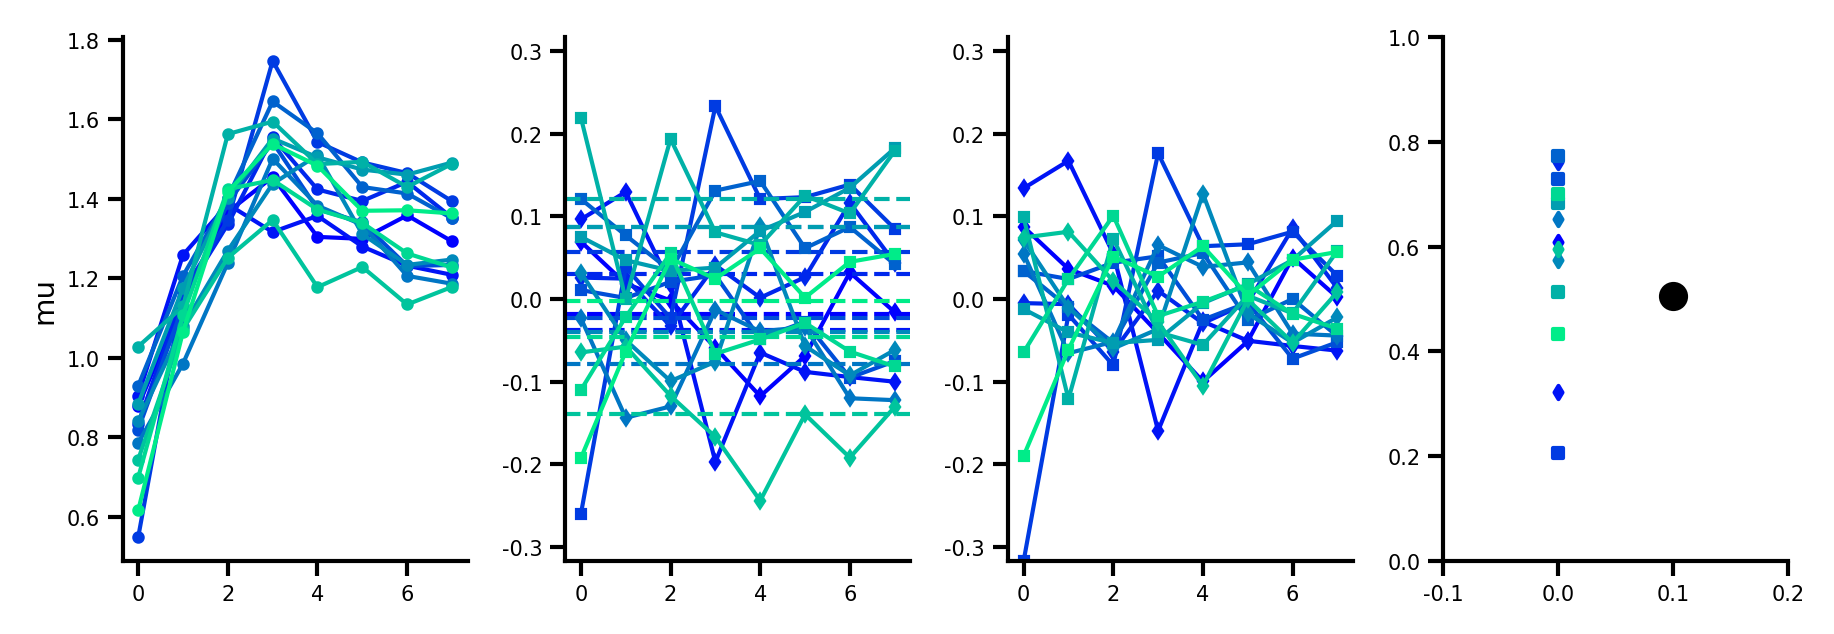

In [418]:
def do_stuff(var, name='', animalList=animalList):
    fig, axs = plt.subplots(1, 4, figsize=(6, 2))

    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]

    expected_60 = np.mean([var[animal]["60"] for animal in animalList])
    expected_90 = np.mean([var[animal]["90"] for animal in animalList])
    expected_120 = np.mean([var[animal]["120"] for animal in animalList])
    expected_20 = np.mean([var[animal]["20"] for animal in animalList])
    expected_10 = np.mean([var[animal]["10"] for animal in animalList])
    expected_2 = np.mean([var[animal]["2"] for animal in animalList])
    expected_rev10 = np.mean([var[animal]["rev10"] for animal in animalList])
    expected_rev20 = np.mean([var[animal]["rev20"] for animal in animalList])

    individual_intercepts = {}
    remaining_residuals = {}
    x = np.arange(len(conds))
    ymax = 0

    for animal in animalList:

        try:
            color = rat_markers[animal][0]
            marker = rat_markers[animal][1]
        except:
            color = 'k'
            marker = 'o'


        y = np.array([
            var[animal]["60"], 
                        var[animal]["90"], 
                        var[animal]["120"],
                        var[animal]["rev20"], 
                        var[animal]["rev10"], 
                        var[animal]["2"], 
                        var[animal]["10"], 
                        var[animal]["20"]])

        axs[0].plot(x, y, label=animal, marker='o', markersize=2, color=color)


        #############################""
        y_expected = np.array([
                                var[animal]["60"] - expected_60,
                                var[animal]["90"] - expected_90,
                                var[animal]["120"] - expected_120,
                                var[animal]["rev20"] - expected_rev20,
                                var[animal]["rev10"] - expected_rev10,
                                var[animal]["2"] - expected_2,
                                var[animal]["10"] - expected_10,
                                var[animal]["20"] - expected_20])


        axs[1].plot(x, y_expected, label=animal, marker=marker, markersize=2, color=color)

        #find intercept
        X = np.ones((len(x), 1))
        Y = y_expected.reshape(-1, 1)
        coefficients = np.linalg.lstsq(X, Y, rcond=None)[0]
        intercept = coefficients[0][0]
        axs[1].axhline(y=intercept, linestyle='--', label='Intercept', color=color)
        individual_intercepts[animal] = intercept

        ######################################

        y_corrected = np.array([
                                var[animal]["60"] - expected_60 - individual_intercepts[animal],
                                var[animal]["90"] - expected_90 - individual_intercepts[animal],
                                var[animal]["120"] - expected_120 - individual_intercepts[animal],
                                var[animal]["rev20"] - expected_rev20 - individual_intercepts[animal],
                                var[animal]["rev10"] - expected_rev10 - individual_intercepts[animal],
                                var[animal]["2"] - expected_2 - individual_intercepts[animal],
                                var[animal]["10"] - expected_10 - individual_intercepts[animal],
                                var[animal]["20"] - expected_20 - individual_intercepts[animal]])
        
        axs[2].plot(x, y_corrected, label=animal, marker=marker, markersize=2, color=color)
        remaining_residuals[animal] = np.var(y_corrected)


        temp_ymax = np.max([np.max(np.abs(y_corrected)), np.max(np.abs(y_expected))])

        if temp_ymax > ymax:
            ymax = temp_ymax



    alp = np.var(list(individual_intercepts.values()))
    eps = np.mean(list(remaining_residuals.values()))
    ICC_pop = alp / (alp + eps)


    # individual ICC
    ICC_indiv = {}
    for animal in animalList:
        try:
            color = rat_markers[animal][0]
            marker = rat_markers[animal][1]
        except:
            color = 'k'
            marker = 'o'
        ICC_indiv[animal] = alp / (alp + remaining_residuals[animal])
        axs[3].scatter(0,  ICC_indiv[animal], color=color, marker=marker, s=5)



    axs[1].set_ylim(-ymax, ymax)
    axs[2].set_ylim(-ymax, ymax)
    
    axs[3].scatter(0.1, ICC_pop, label="ICC_pop", color='black')
    axs[3].set_ylim(0, 1)
    axs[3].set_xlim(-0.1, 0.2)

    axs[0].set_ylabel(name)
    plt.show()

do_stuff(mu, 'mu')
# do_stuff(sigma)
# do_stuff(alpha, 'alpha')

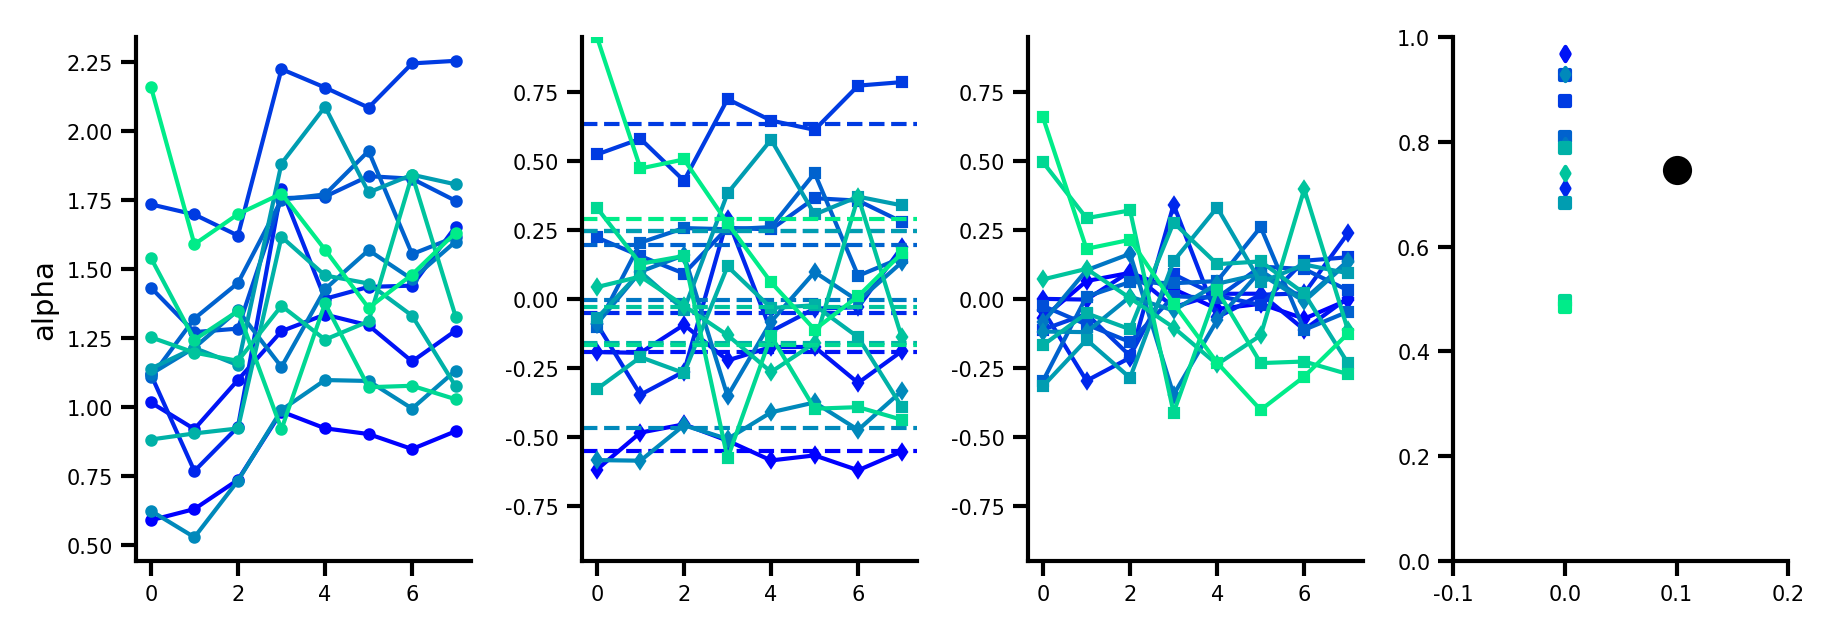

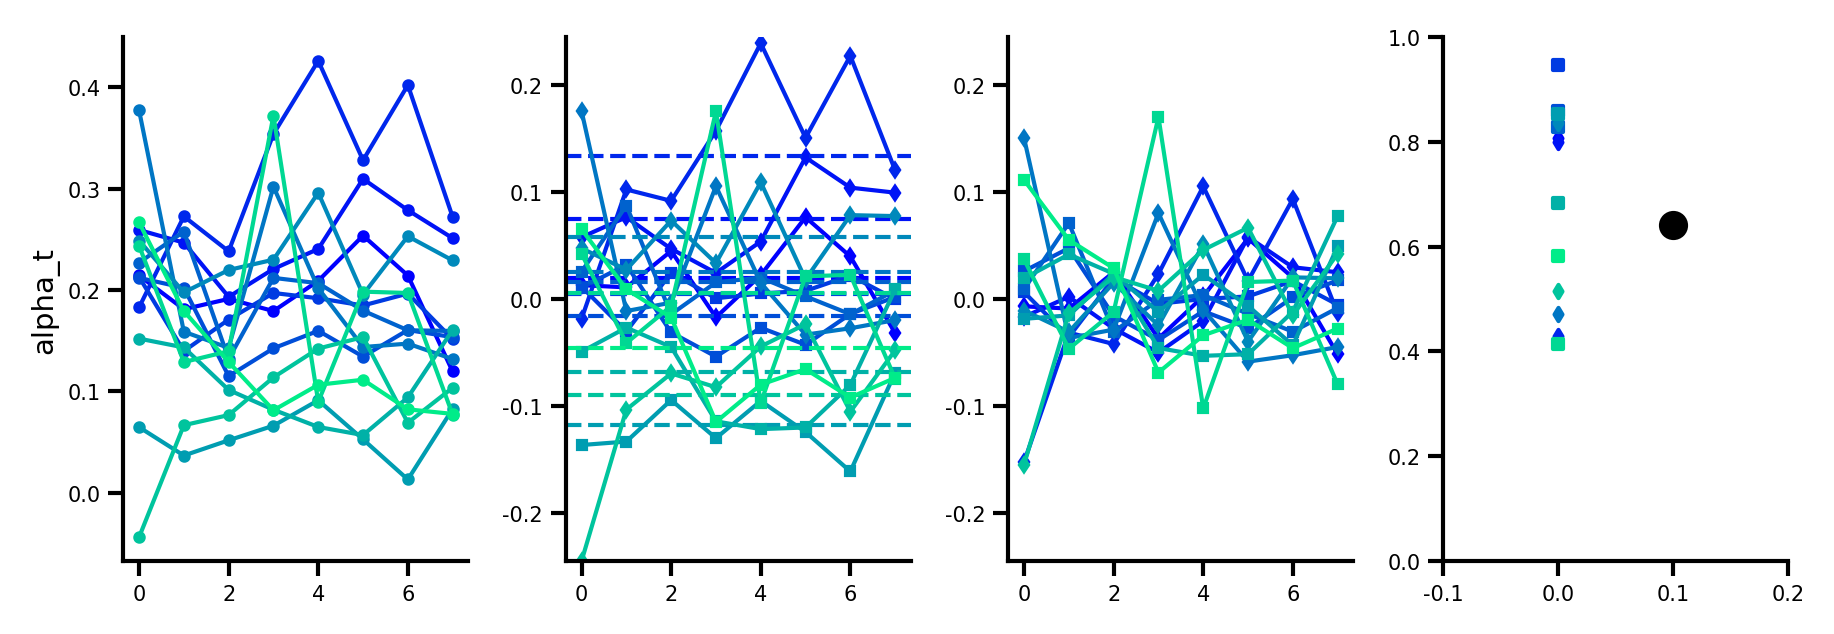

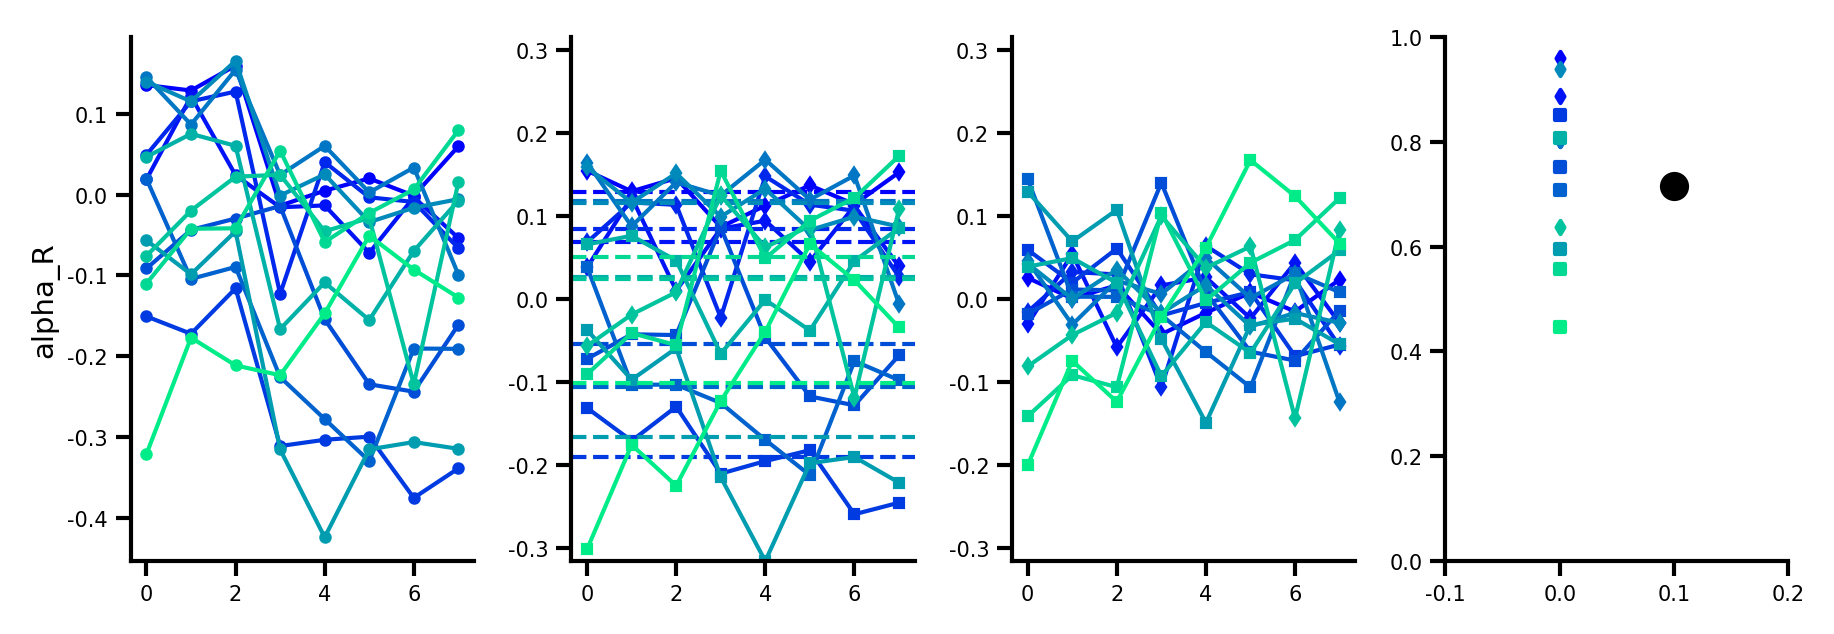

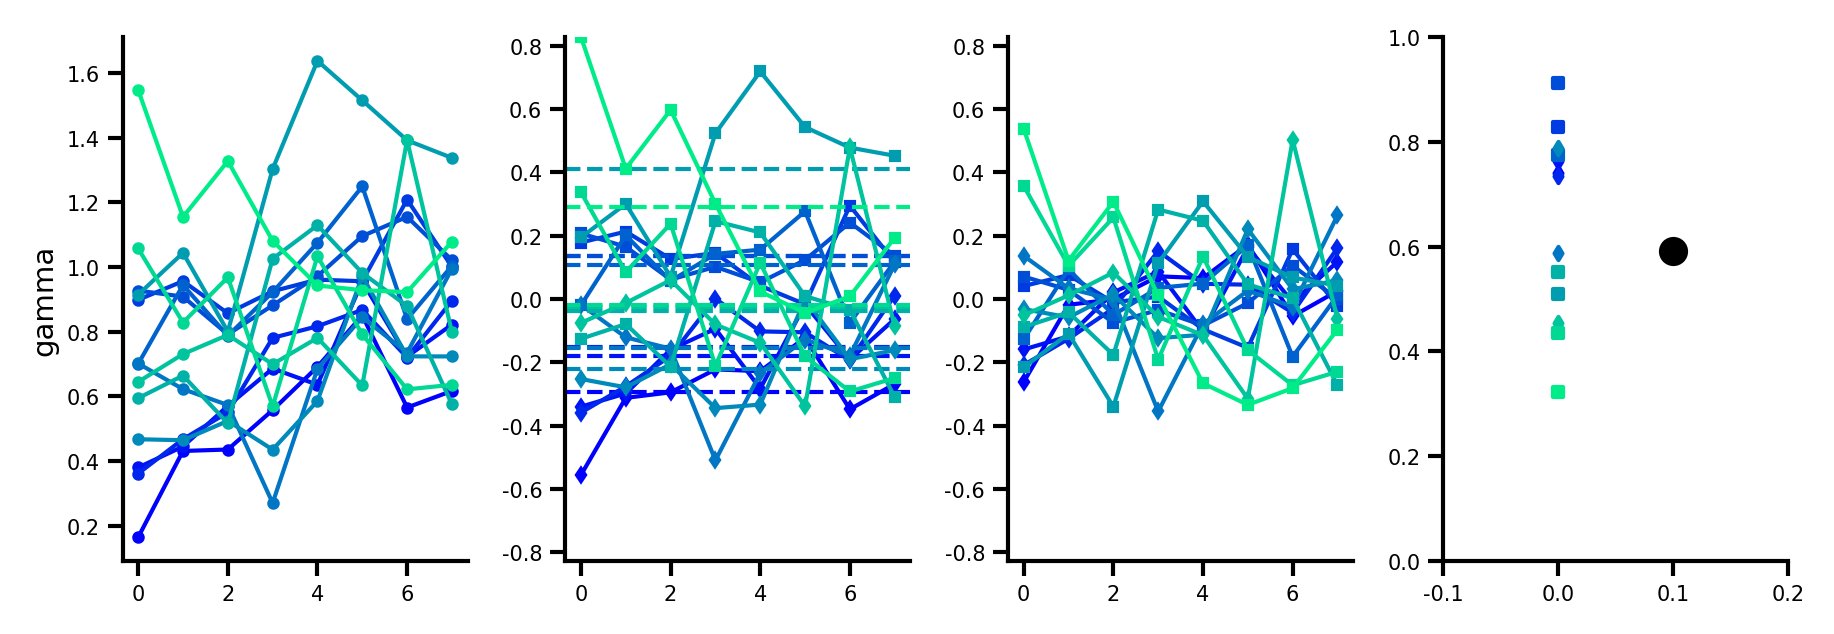

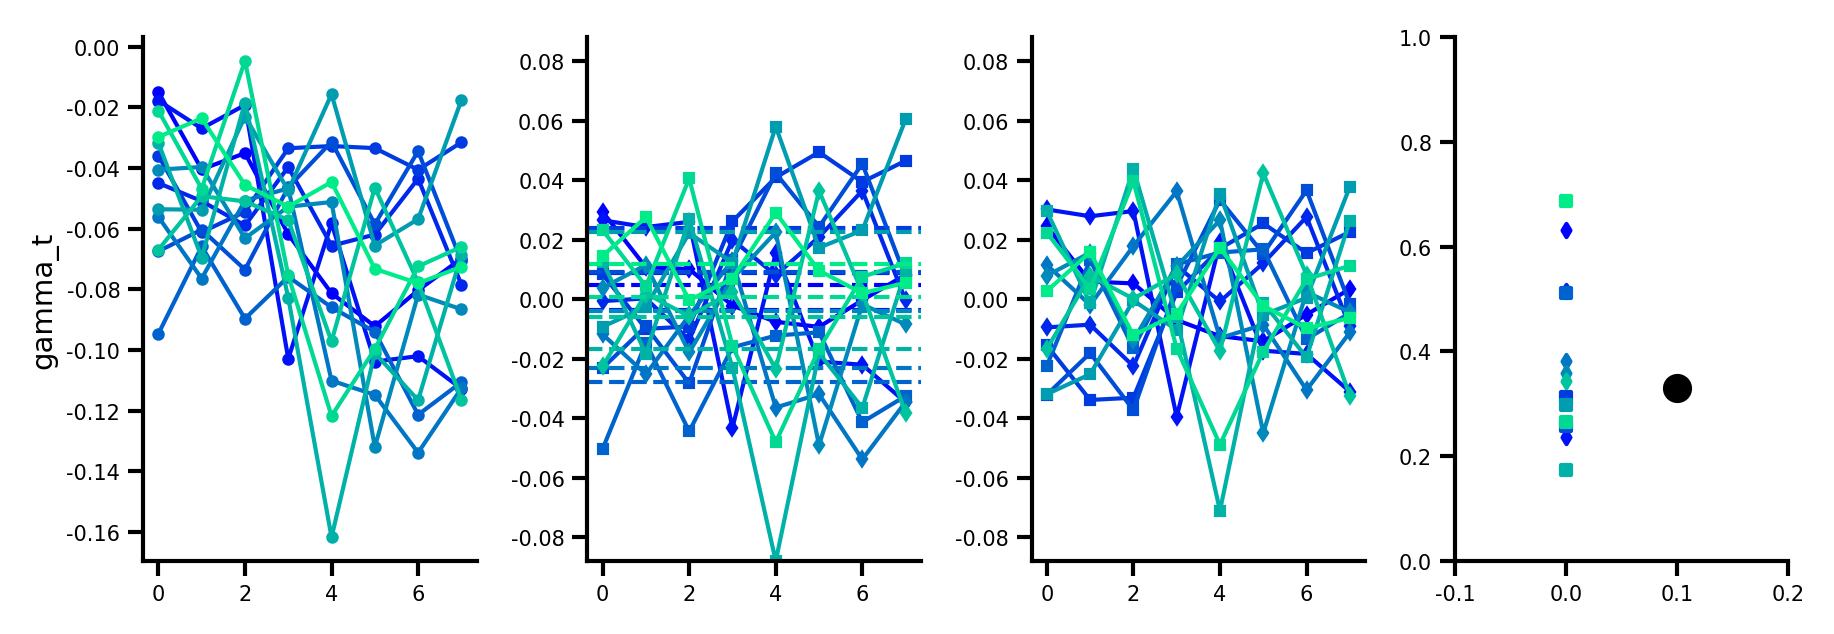

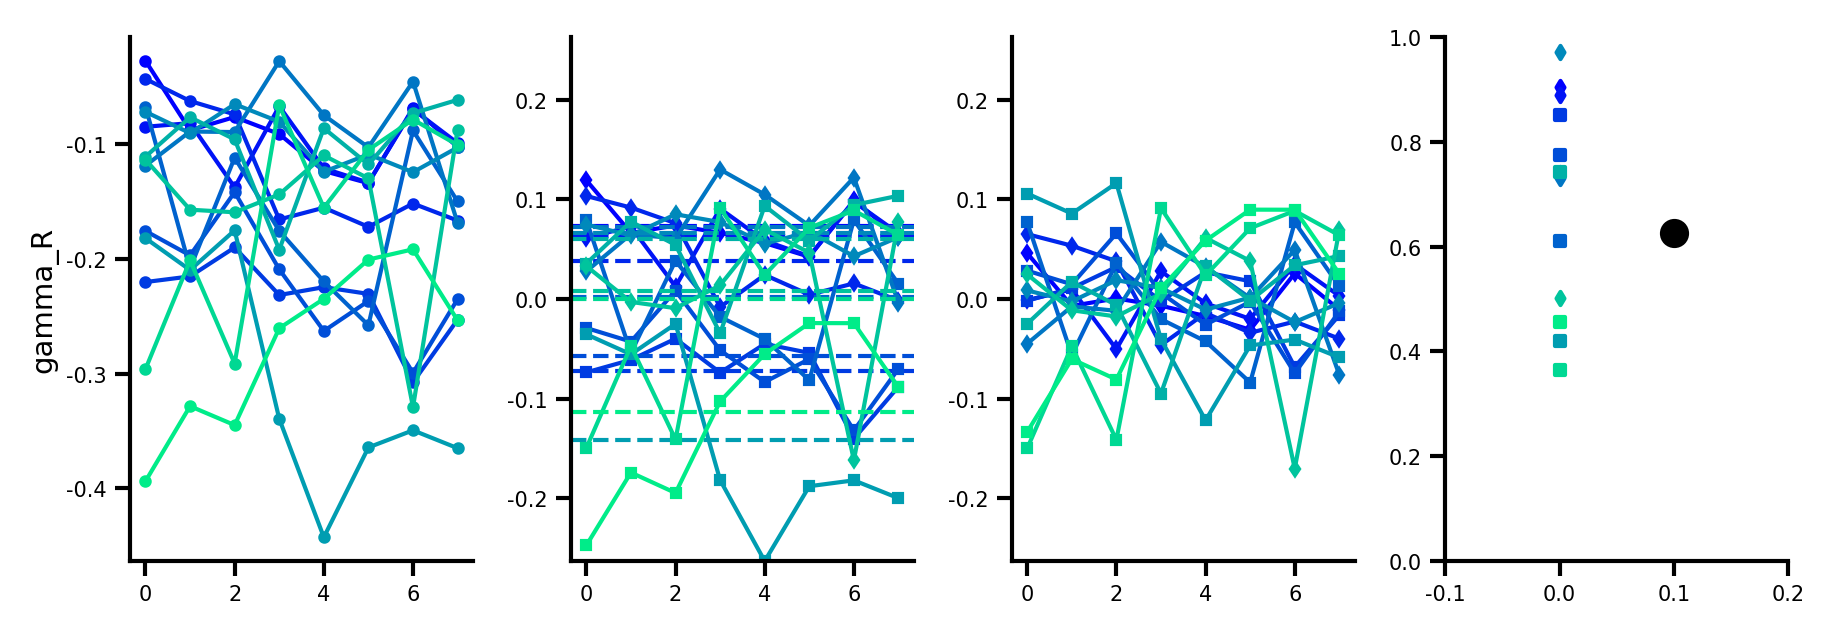

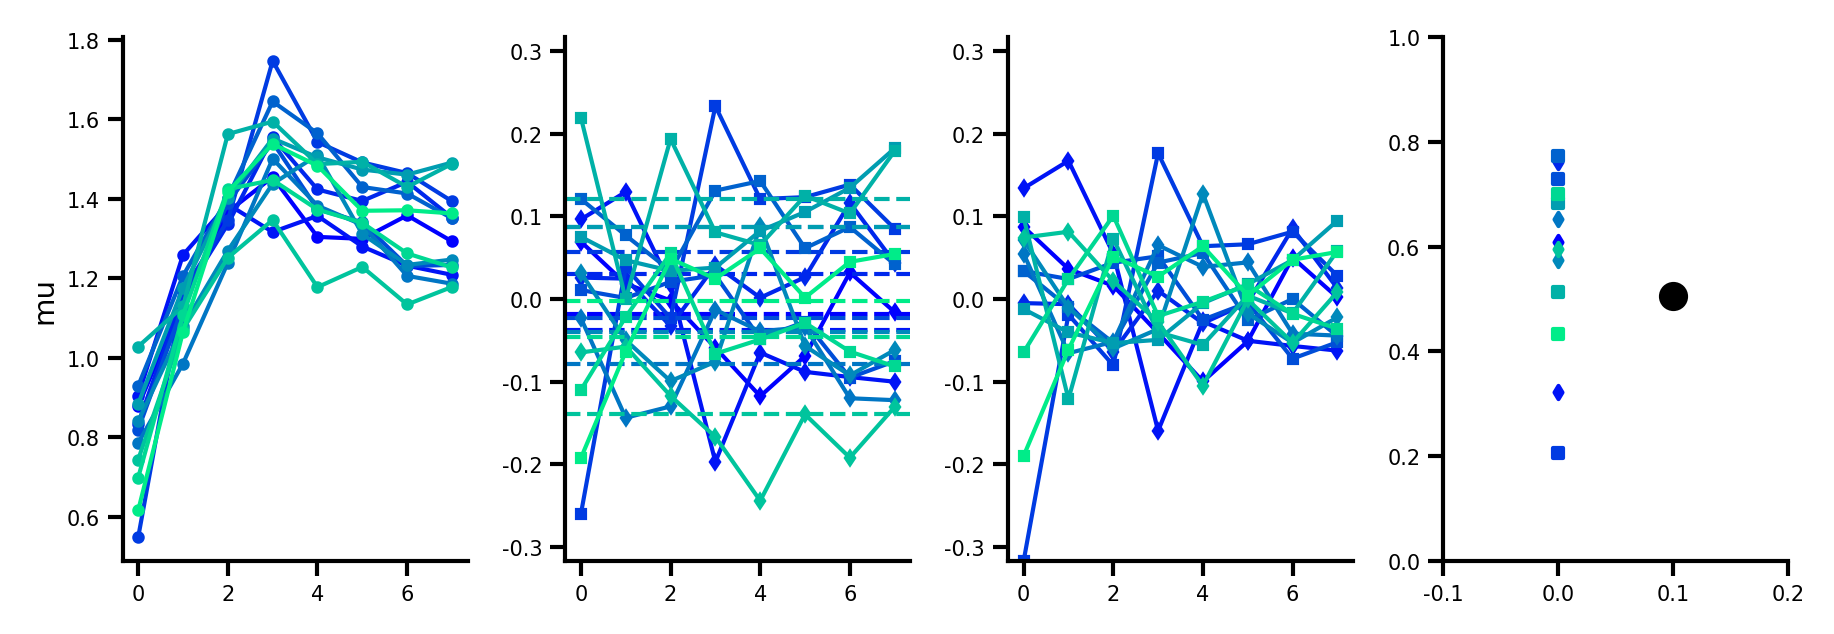

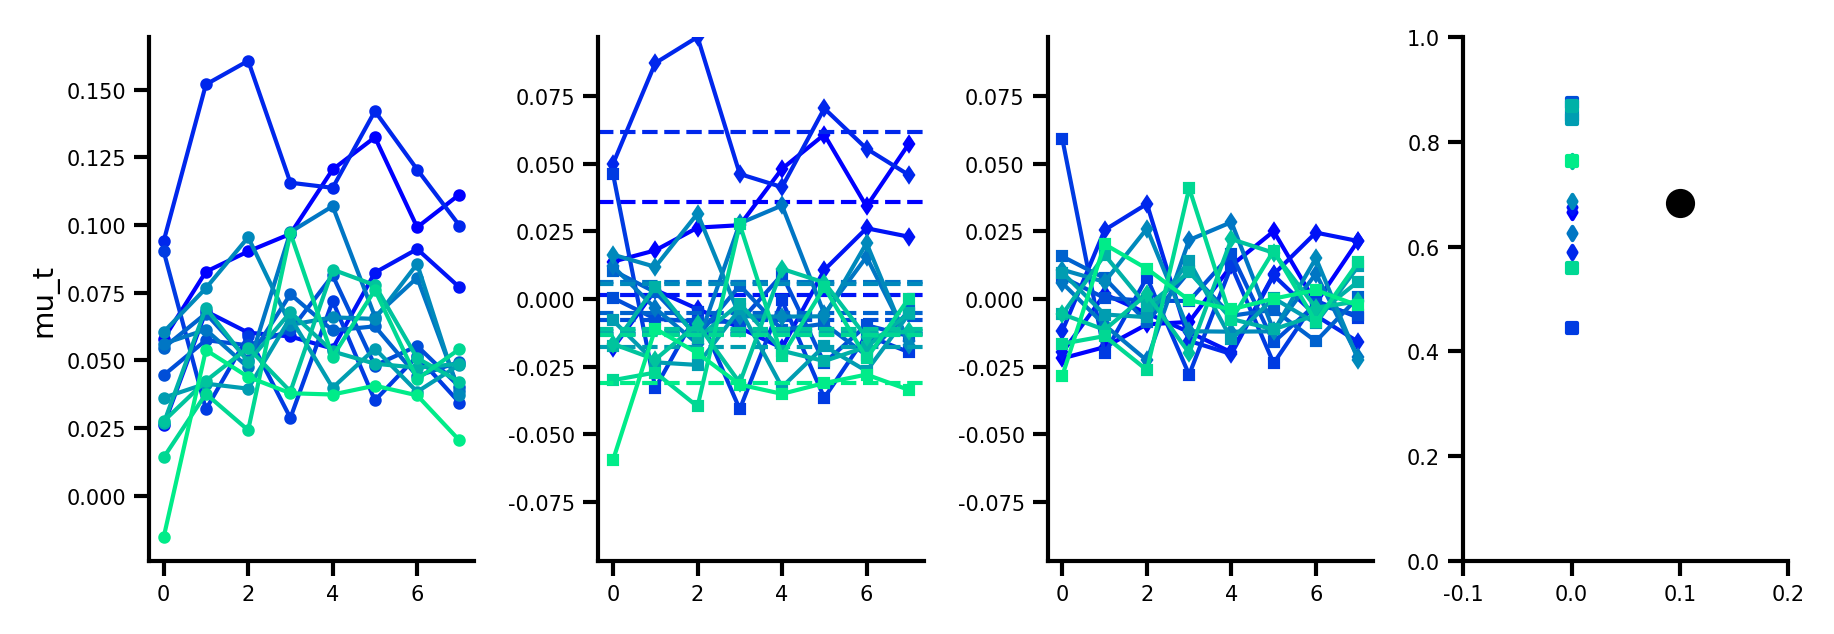

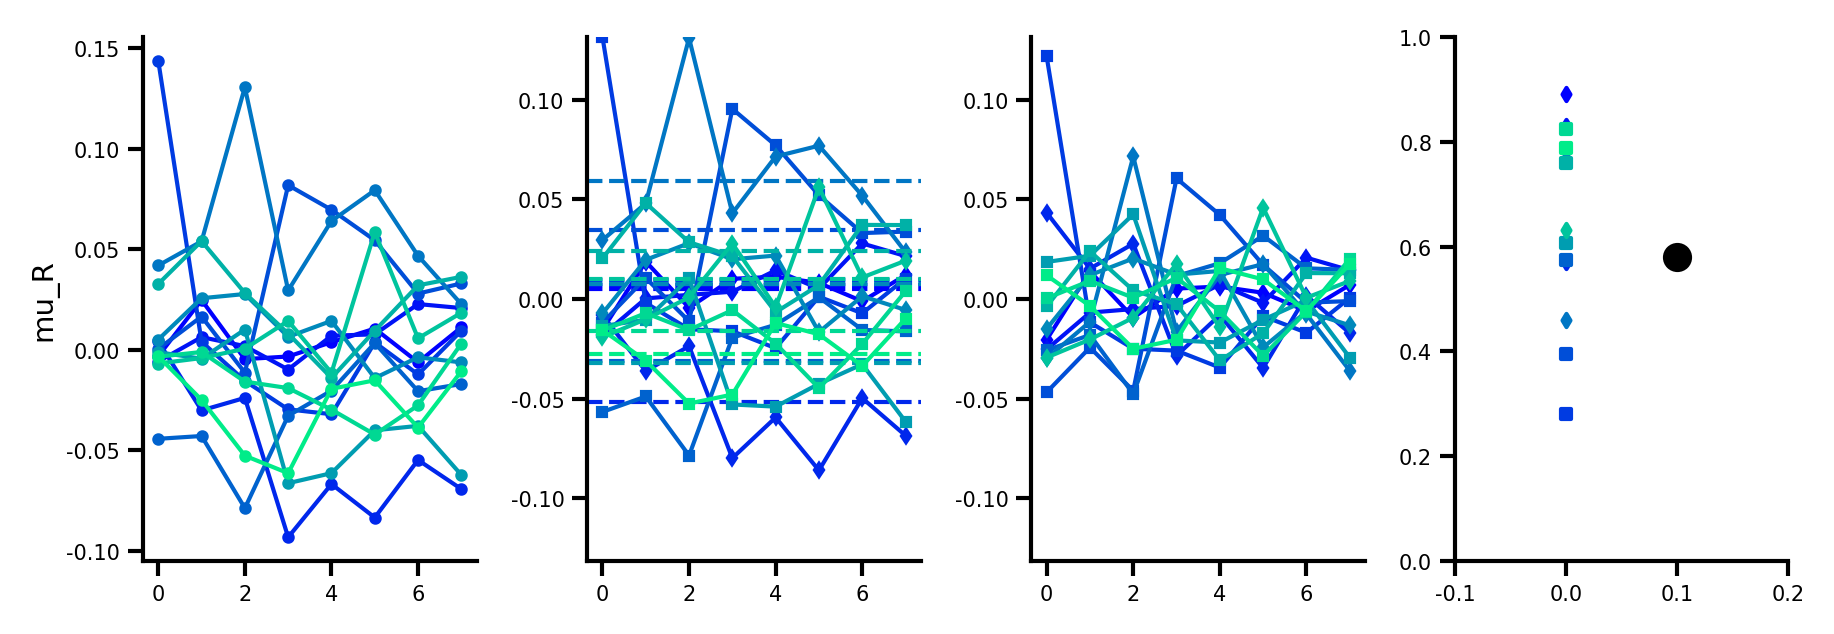

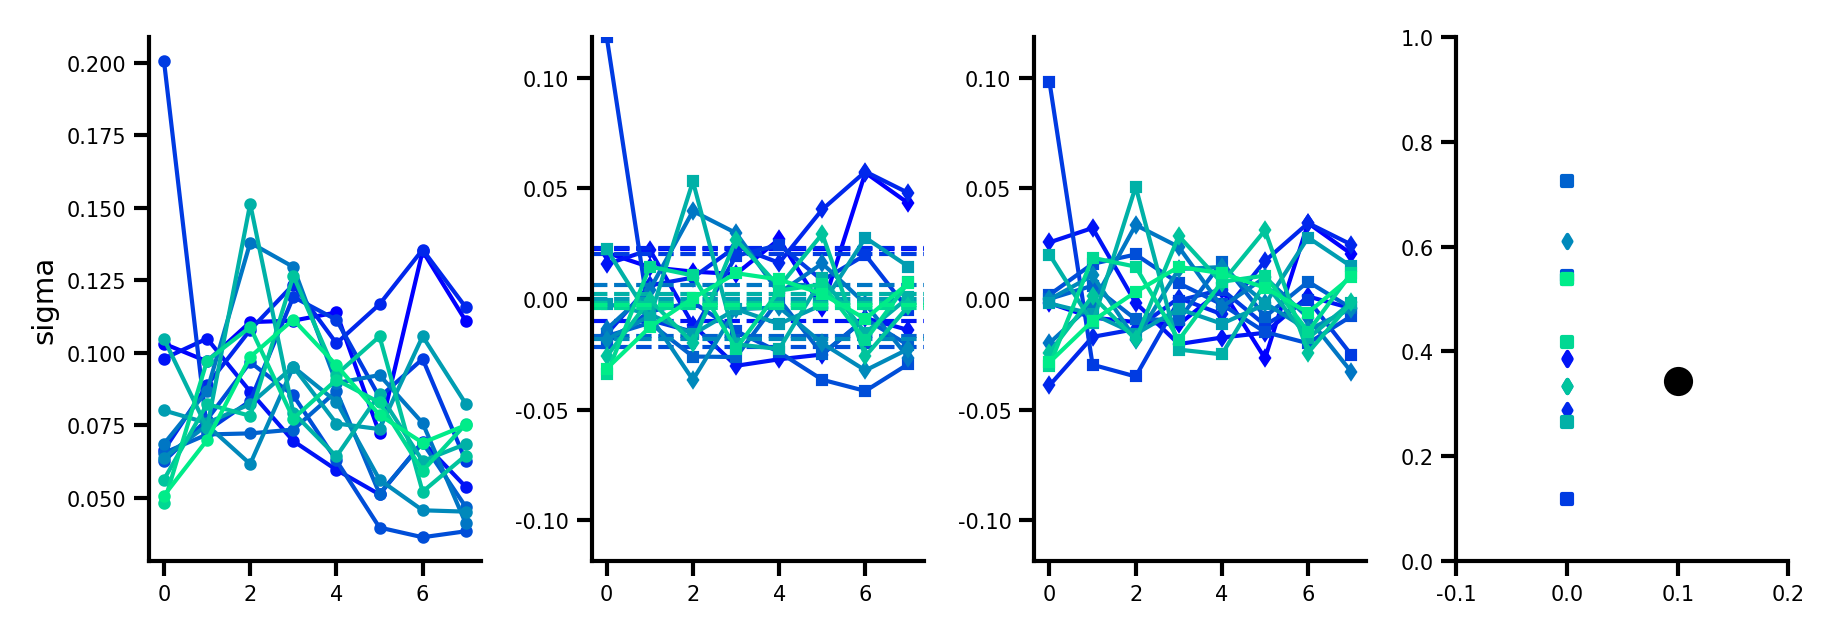

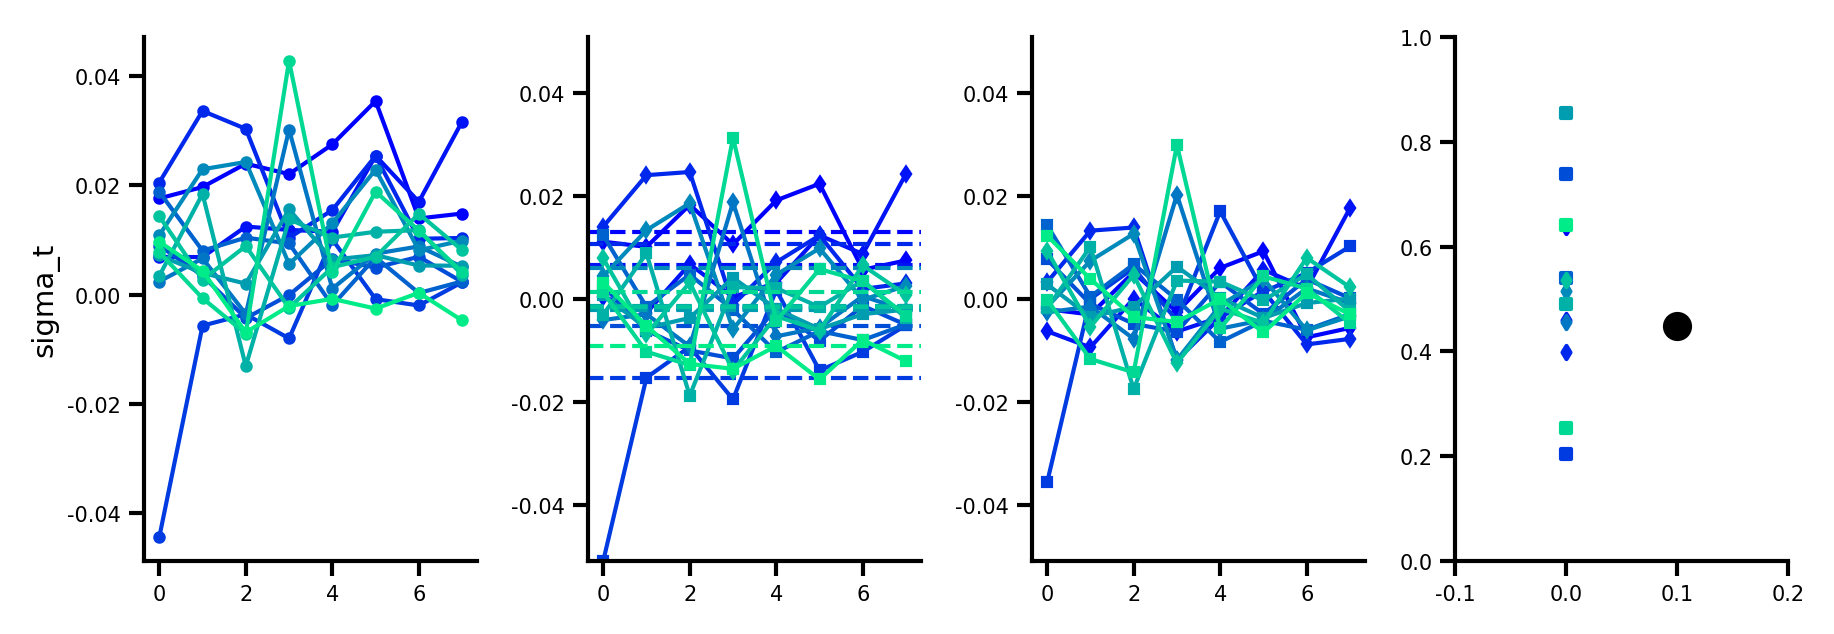

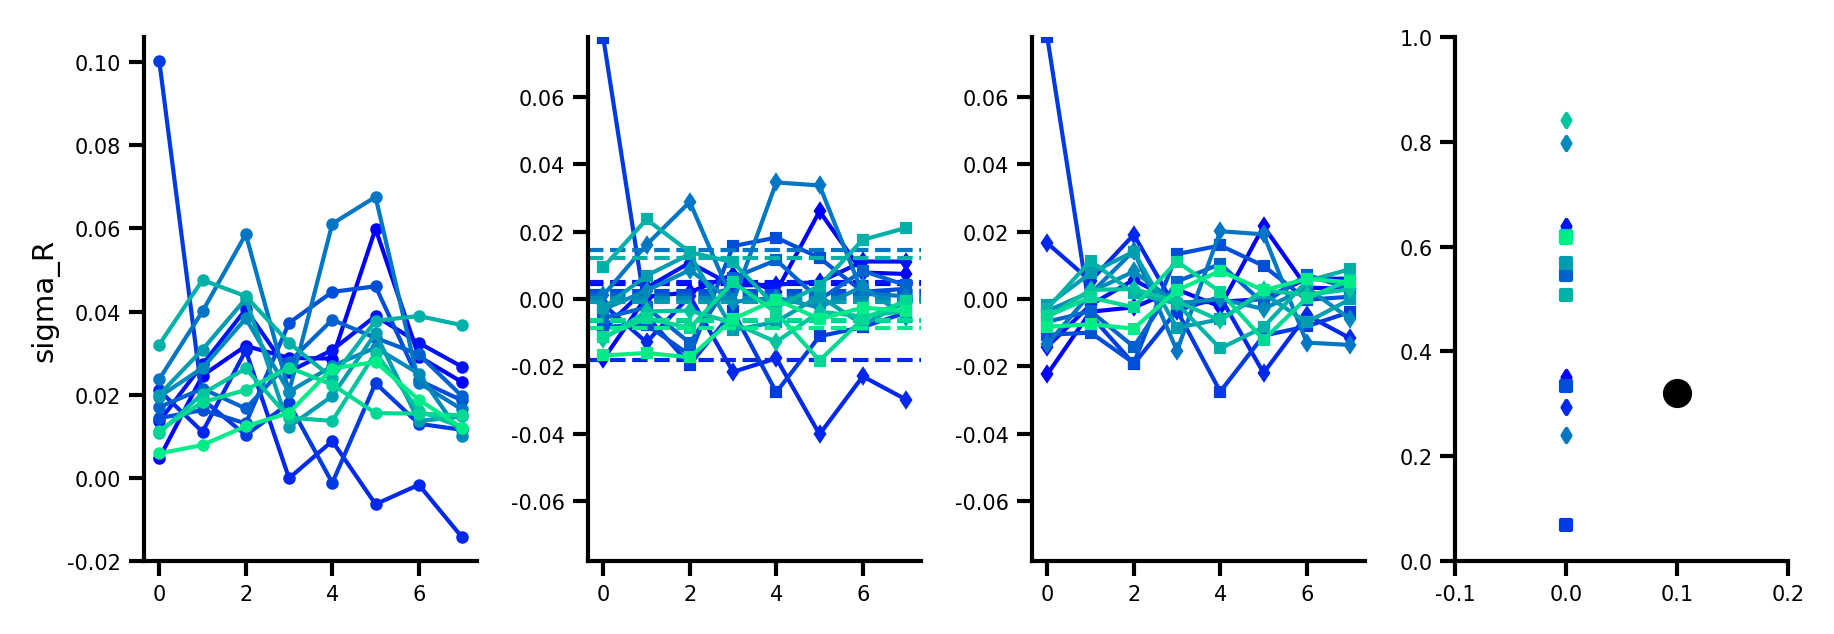

In [419]:
for var, n in zip(vars, names):
    do_stuff(var, n)

In [420]:
conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]
def compute_ICC(var, animalList=animalList):
    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]

    expected_60 = np.mean([var[animal]["60"] for animal in animalList])
    expected_90 = np.mean([var[animal]["90"] for animal in animalList])
    expected_120 = np.mean([var[animal]["120"] for animal in animalList])
    expected_20 = np.mean([var[animal]["20"] for animal in animalList])
    expected_10 = np.mean([var[animal]["10"] for animal in animalList])
    expected_2 = np.mean([var[animal]["2"] for animal in animalList])
    expected_rev10 = np.mean([var[animal]["rev10"] for animal in animalList])
    expected_rev20 = np.mean([var[animal]["rev20"] for animal in animalList])

    individual_intercepts = {}
    remaining_residuals = {}
    x = np.arange(len(conds))
    ymax = 0

    for animal in animalList:
        y = np.array([
            var[animal]["60"], 
                        var[animal]["90"], 
                        var[animal]["120"],
                        var[animal]["rev20"], 
                        var[animal]["rev10"], 
                        var[animal]["2"], 
                        var[animal]["10"], 
                        var[animal]["20"]])

        y_expected = np.array([
                                var[animal]["60"] - expected_60,
                                var[animal]["90"] - expected_90,
                                var[animal]["120"] - expected_120,
                                var[animal]["rev20"] - expected_rev20,
                                var[animal]["rev10"] - expected_rev10,
                                var[animal]["2"] - expected_2,
                                var[animal]["10"] - expected_10,
                                var[animal]["20"] - expected_20])


        #find intercept
        X = np.ones((len(x), 1))
        Y = y_expected.reshape(-1, 1)
        coefficients = np.linalg.lstsq(X, Y, rcond=None)[0]
        intercept = coefficients[0][0]
        individual_intercepts[animal] = intercept

        ######################################

        y_corrected = np.array([
                                var[animal]["60"] - expected_60 - individual_intercepts[animal],
                                var[animal]["90"] - expected_90 - individual_intercepts[animal],
                                var[animal]["120"] - expected_120 - individual_intercepts[animal],
                                var[animal]["rev20"] - expected_rev20 - individual_intercepts[animal],
                                var[animal]["rev10"] - expected_rev10 - individual_intercepts[animal],
                                var[animal]["2"] - expected_2 - individual_intercepts[animal],
                                var[animal]["10"] - expected_10 - individual_intercepts[animal],
                                var[animal]["20"] - expected_20 - individual_intercepts[animal]])
        
        
        remaining_residuals[animal] = np.var(y_corrected)

    alp = np.var(list(individual_intercepts.values()))
    eps = np.mean(list(remaining_residuals.values()))
    # print(alp, eps)
    ICC_pop = alp / (alp + eps)


    # individual ICC
    ICC_indiv = {}
    for animal in animalList:
        ICC_indiv[animal] = alp / (alp + remaining_residuals[animal])

    return ICC_pop, ICC_indiv

compute_ICC(alpha, animalList=animalList)
# # do_stuff(sigma)
# do_stuff(alpha, 'alpha')

(0.7466062431114343,
 {'RatF00': 0.9675595659845672,
  'RatF01': 0.970082086125903,
  'RatF02': 0.7125831268262854,
  'RatM00': 0.8772364640757968,
  'RatM01': 0.9280511837983261,
  'RatM02': 0.809834235563045,
  'RatF32': 0.7942208763960448,
  'RatF33': 0.929196173637899,
  'RatM31': 0.6830087492059087,
  'RatM32': 0.788401461302012,
  'RatF42': 0.7405203323694135,
  'RatM40': 0.49685310437940006,
  'RatM43': 0.48514119260248034})

(0.5747922352386516, 0.8683787438152896)

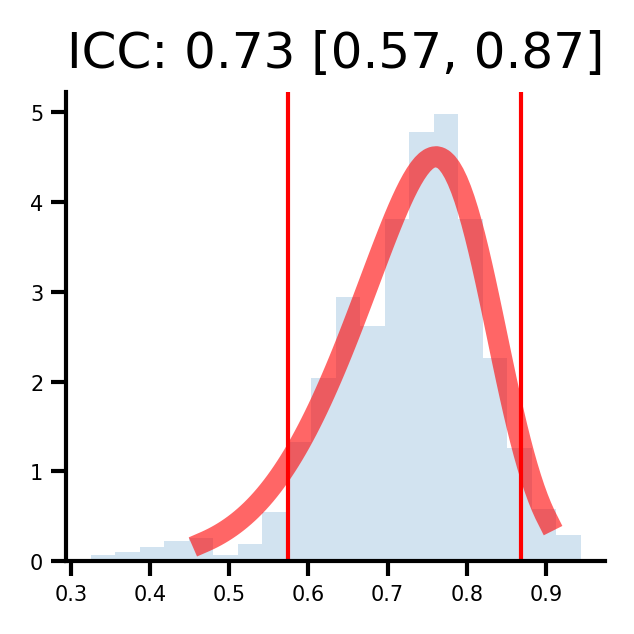

In [452]:

def bootstrap_ICC(var, animalList=animalList, num_bootstrap=1000, plot=False):
    icc_values = np.zeros(num_bootstrap)
    bootstrap_samples = []

    for _ in range(num_bootstrap):
        bootstrap_animals = np.random.choice(animalList, size=len(animalList), replace=True)
        bootstrap_sample = {animal: {} for animal in bootstrap_animals}
        
        for animal in bootstrap_animals:
            for cond, value in var[animal].items():
                bootstrap_sample[animal][cond] = value

        icc_values[_] = compute_ICC(bootstrap_sample, animalList=bootstrap_animals)[0]
        bootstrap_samples.append(bootstrap_sample)

    #fit skew normal
    a, loc, scale = stats.skewnorm.fit(icc_values)
    x = np.linspace(stats.skewnorm.ppf(0.01, a, loc, scale),
                    stats.skewnorm.ppf(0.99, a, loc, scale), 100)
    y = stats.skewnorm.pdf(x, a, loc, scale)

    lower_bound = np.percentile(icc_values, 5)
    upper_bound = np.percentile(icc_values, 95)

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))
        ax.plot(x, y, 'r-', lw=5, alpha=0.6, label='skewnorm pdf')
        ax.hist(icc_values, bins=20, density=True, histtype='stepfilled', alpha=0.2)
        ax.axvline(lower_bound, color='red')
        ax.axvline(upper_bound, color='red')
        ax.set_title('ICC: {:.2f} [{:.2f}, {:.2f}]'.format(np.mean(icc_values), lower_bound, upper_bound))

    return lower_bound, upper_bound


bootstrap_ICC(alpha, animalList=animalList, num_bootstrap=1000, plot=True)

In [ ]:
# not working
def generate_bootstrap_samples(var, intercept_variance, residual_variance, n=1000):
    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]
    samples = []
    for i in range(n):
        sample = {}
        for animal in animalList:
            sample[animal] = {}
            for cond in conds:

                expected = np.mean([var[animal][cond] for animal in animalList])
                sample[animal][cond] = var[animal][cond] - expected + np.random.normal(0, np.sqrt(intercept_variance)) + np.random.normal(0, np.sqrt(residual_variance))

        samples.append(sample)
    return samples

n = 10
ICCs = np.zeros(n)
for i, sample in enumerate(generate_bootstrap_samples(alpha,  
                                                    0.09718749881658037, 0.03298486407655271, 
                                                    n=n)):
    ICC_pop, ICC_indiv = compute_ICC(sample)
    ICCs[i] = ICC_pop

conf_bottom = np.percentile(ICCs, 5)
conf_top = np.percentile(ICCs, 95)

plt.hist(ICCs, bins=np.arange(0, 1, 0.05))
plt.axvline(conf_bottom, color='black')
plt.axvline(conf_top, color='black')
print(conf_bottom, conf_top)


alpha M vs F p = 0.1643
alpha M vs F p = MannwhitneyuResult(statistic=11.0, pvalue=0.18065268065268064)
alpha_t M vs F p = 0.3693
alpha_t M vs F p = MannwhitneyuResult(statistic=29.0, pvalue=0.2948717948717949)
alpha_R M vs F p = 0.0532
alpha_R M vs F p = MannwhitneyuResult(statistic=8.0, pvalue=0.07342657342657342)
gamma M vs F p = 0.5735
gamma M vs F p = MannwhitneyuResult(statistic=19.0, pvalue=0.8356643356643356)
gamma_t M vs F p = 0.5539
gamma_t M vs F p = MannwhitneyuResult(statistic=14.0, pvalue=0.36596736596736595)
gamma_R M vs F p = 0.0907
gamma_R M vs F p = MannwhitneyuResult(statistic=10.0, pvalue=0.13752913752913754)
mu M vs F p = 0.9316
mu M vs F p = MannwhitneyuResult(statistic=23.0, pvalue=0.8356643356643356)
mu_t M vs F p = 0.3308
mu_t M vs F p = MannwhitneyuResult(statistic=29.0, pvalue=0.2948717948717949)
mu_R M vs F p = 0.4103
mu_R M vs F p = MannwhitneyuResult(statistic=15.0, pvalue=0.4452214452214452)
sigma M vs F p = 0.5374
sigma M vs F p = MannwhitneyuResult(stat

(0.0, 1.0)

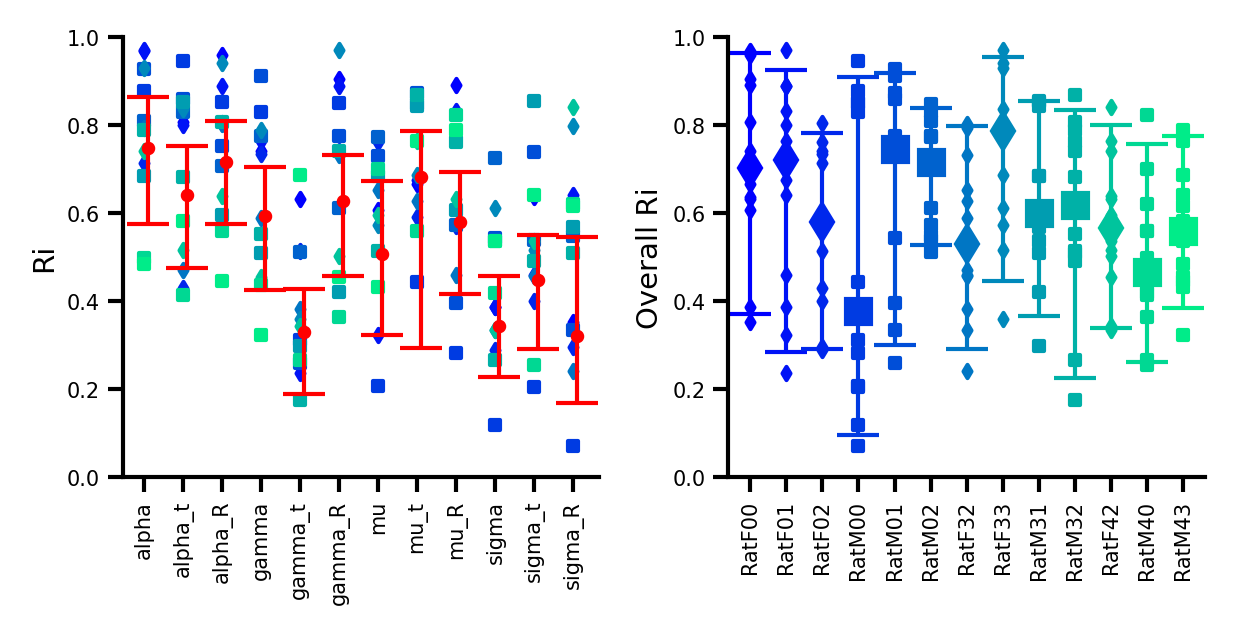

In [447]:
vars = alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R
names = ('alpha', 'alpha_t', 'alpha_R', 'gamma', 'gamma_t', 'gamma_R', 'mu', 'mu_t', 'mu_R', 'sigma', 'sigma_t', 'sigma_R')

populationRi = {}
conf_bottom = {}
conf_top = {}
indivRi = {}

fig, axs = plt.subplots(1, 2, figsize=(4, 2))

for i, (var, name) in enumerate(zip(vars, names)):
    populationRi[name], indivRi[name] = compute_ICC(var)
    conf_bottom[name], conf_top[name] = bootstrap_ICC(var)

for i, (var, name) in enumerate(zip(vars, names)):
    femalesRi = [indivRi[name][animal] for animal in animalList if 'F' in animal]
    malesRi = [indivRi[name][animal] for animal in animalList if 'M' in animal]

    print(f'{name} M vs F p = {exact_mc_perm_test(malesRi, femalesRi)}')
    print(f'{name} M vs F p = {stats.mannwhitneyu(malesRi, femalesRi)}')

    for animal in animalList:
        axs[0].scatter(i, indivRi[name][animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    axs[0].scatter(i+.1, populationRi[name], color='r', s=5)
    axs[0].errorbar(i+.1, populationRi[name], yerr=[[populationRi[name] - conf_bottom[name]], [conf_top[name] - populationRi[name]]], color='r', capsize=5, capthick=1)

    

for i, animal in enumerate(animalList):

    axs[1].scatter([i] * len([indivRi[name][animal] for name in names]),
                    [indivRi[name][animal] for name in names],
                    color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
                    
    lower = np.percentile([indivRi[name][animal] for name in names], 5)
    upper = np.percentile([indivRi[name][animal] for name in names], 95)

    axs[1].errorbar(i, np.median([indivRi[name][animal] for name in names]), 
                    yerr=[[np.median([indivRi[name][animal] for name in names]) - lower], 
                            [upper - np.median([indivRi[name][animal] for name in names])]],
                    color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                    capsize=5, capthick=1, elinewidth=1)


axs[0].set_xticks(range(len(vars)))
axs[0].set_xticklabels(names, rotation=90)
axs[0].set_ylabel('Ri')
axs[0].set_ylim(0, 1)
# axs[0].set_yticklabels('')
# axs[0].set_yticks([0, 0.5, 0.75, .9, 1])
# axs[0].set_yticks([0.25, 0.625, 0.825, .95], minor=True)
# axs[0].set_yticklabels(["Poor", "Moderate", "Good", "Excellent"], minor=True)
# axs[0].tick_params(which='minor', length=0)



axs[1].set_xticks(range(len(animalList)))
axs[1].set_xticklabels(animalList, rotation=90)
axs[1].set_ylabel('Overall Ri')
axs[1].set_ylim(0, 1)
# axs[1].set_yticklabels('')
# axs[1].set_yticks([0, 0.5, 0.75, .9, 1])
# axs[1].set_yticks([0.25, 0.625, 0.825, .95], minor=True)
# axs[1].set_yticklabels(["Poor", "Moderate", "Good", "Excellent"], minor=True)
# axs[1].tick_params(which='minor', length=0)


In [76]:
values = []
for key, rat_data in indivRi.items():
    values.append(list(rat_data.values()))

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*values)

print("F-statistic:", f_statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print("There are significant differences between individuals.")
else:
    print("There are no significant differences between individuals.")

F-statistic: 7.028832753058896
p-value: 1.8585472458840567e-09
There are significant differences between individuals.


In [81]:
# Perform normality test for each group
normality_passed = True
for group_values in values:
    _, p_value = stats.shapiro(group_values)
    print(stats.shapiro(group_values))
    if p_value < 0.05:
        normality_passed = False
        break

if normality_passed:
    f_statistic, p_value = stats.f_oneway(*values)
    
    print("F-statistic:", f_statistic)
    print("p-value:", p_value)

    if p_value < 0.05:
        print("There are significant differences between individuals.")
    else:
        print("There are no significant differences between individuals.")
else:
    print("The normality assumption is violated. Consider using non-parametric tests.")

ShapiroResult(statistic=0.9059577584266663, pvalue=0.16142801940441132)
ShapiroResult(statistic=0.8794867992401123, pvalue=0.07017853856086731)
ShapiroResult(statistic=0.9566210508346558, pvalue=0.700970470905304)
ShapiroResult(statistic=0.9400346875190735, pvalue=0.45735129714012146)
ShapiroResult(statistic=0.9167827367782593, pvalue=0.22691544890403748)
ShapiroResult(statistic=0.9315981268882751, pvalue=0.35756435990333557)
ShapiroResult(statistic=0.9071025848388672, pvalue=0.1673695594072342)
ShapiroResult(statistic=0.9416714906692505, pvalue=0.47890883684158325)
ShapiroResult(statistic=0.9355543851852417, pvalue=0.4019649624824524)
ShapiroResult(statistic=0.9764583110809326, pvalue=0.9576933979988098)
ShapiroResult(statistic=0.9734112024307251, pvalue=0.9313715696334839)
ShapiroResult(statistic=0.9655953049659729, pvalue=0.8367646932601929)
F-statistic: 7.028832753058896
p-value: 1.8585472458840567e-09
There are significant differences between individuals.


In [85]:
male_data = []
female_data = []

for key, rat_data in indivRi.items():
    male_data.extend([value for rat, value in rat_data.items() if rat.startswith('RatM')])
    female_data.extend([value for rat, value in rat_data.items() if rat.startswith('RatF')])

# Perform t-test for normally distributed data
t_statistic, p_value_t = stats.ttest_ind(male_data, female_data)

# Perform Mann-Whitney U test for non-normally distributed data
u_statistic, p_value_mw = stats.mannwhitneyu(male_data, female_data)

perm = exact_mc_perm_test(male_data, female_data, 10000)

print("T-test results:")
print("t-statistic:", t_statistic)
print("p-value (t-test):", p_value_t)

print("Mann-Whitney U test results:")
print("U-statistic:", u_statistic)
print("p-value (Mann-Whitney U):", p_value_mw)

print("Permutation test results:")
print("p-value (permutation test):", perm)


alpha = 0.05

if p_value_t < alpha:
    print("There are significant differences between male and female rats (t-test).")
else:
    print("There are no significant differences between male and female rats (t-test).")

if p_value_mw < alpha:
    print("There are significant differences between male and female rats (Mann-Whitney U test).")
else:
    print("There are no significant differences between male and female rats (Mann-Whitney U test).")

if perm < alpha:
    print("There are significant differences between male and female rats (perm test).")
else:
    print("There are no significant differences between male and female rats (perm test).")


T-test results:
t-statistic: -1.2179476264605502
p-value (t-test): 0.22510664508150702
Mann-Whitney U test results:
U-statistic: 2729.0
p-value (Mann-Whitney U): 0.29512901789538615
Permutation test results:
p-value (permutation test): 0.2252
There are no significant differences between male and female rats (t-test).
There are no significant differences between male and female rats (Mann-Whitney U test).
There are no significant differences between male and female rats (perm test).


 corr: 0.69, p: 0.0094
 corr: -0.52, p: 0.0685
 corr: -0.02, p: 0.9539


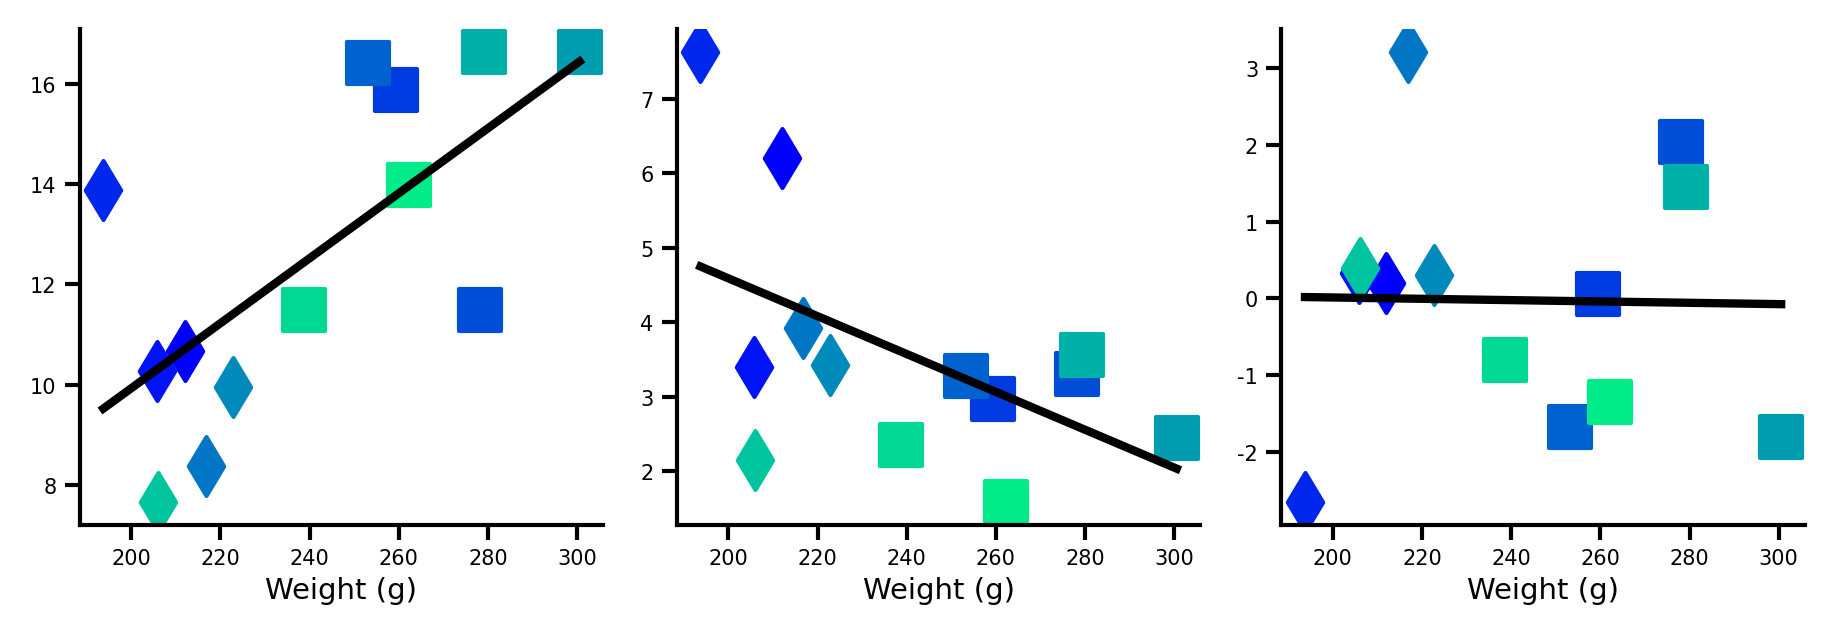

In [242]:
weights = {'RatF00': 212.02, 'RatF01': 205.85, 'RatF02': 193.75,
            'RatM00': 259.37, 'RatM01': 278.12, 'RatM02': 253.19,
            # 'RatF20': 220.10, 'RatF21': 215.53, 'RatF22': 215.0,
            # 'RatM20': 254.68, 'RatM21': 307.29, 'RatM22': 330.53,
            'RatF30': 217.32, 'RatF31': 228.95, 'RatF32': 216.80, 'RatF33': 222.77,
            'RatM30': 261.38, 'RatM31': 300.55, 'RatM32': 279.23, 
            # 'RatF30L': 217.32, 'RatF31L': 228.95, 'RatF32L': 216.80, 'RatF33L': 222.77,
            # 'RatM30L': 261.38, 'RatM31L': 300.55, 'RatM32L': 279.23
            'RatF40': 196.85, 'RatF41': 199.24, 'RatF42': 206.02,
            'RatM40': 238.70, 'RatM41': 238.19, 'RatM42': 242.87, 'RatM43': 262.23}


epsilon_0, epsilon_t, epsilon_R = pickle.load(open("picklejar/effort_fit.p", "rb"))
epss = [epsilon_0, epsilon_t, epsilon_R]

fig, ax = plt.subplots(1, 3, figsize=(6, 2))
for j, var in enumerate(epss):
    _x, _y = [], []
    for animal in animalList:
        # zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        y = var[animal]
        x = weights[animal]
        # y /= x

        ax[j].scatter(x, y, color=rat_markers[animal][0], marker=rat_markers[animal][1], s=100)
        ax[j].set_xlabel("Weight (g)")
        # ax[j].set_ylabel(ylabelsIDLE[j])
        # ax[j].set_ylim(-2, 2)

        _x.append(x)
        _y.append(y)

    pearson = stats.pearsonr(_x, _y)
    print(f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(_x, _y)
    ax[j].plot(np.linspace(np.min(_x), np.max(_x), 100), gradient * np.linspace(np.min(_x), np.max(_x), 100) + intercept, color='black', lw=2)


In [240]:
epsilon_0, epsilon_t, epsilon_R = pickle.load(open("picklejar/effort_fit.p", "rb"))

epsilon_0_Males = [epsilon_0[animal] for animal in animalList if animal.startswith('RatM')]
epsilon_0_Females = [epsilon_0[animal] for animal in animalList if animal.startswith('RatF')]

epsilon_t_Males = [epsilon_t[animal] for animal in animalList if animal.startswith('RatM')]
epsilon_t_Females = [epsilon_t[animal] for animal in animalList if animal.startswith('RatF')]

epsilon_R_Males = [epsilon_R[animal] for animal in animalList if animal.startswith('RatM')]
epsilon_R_Females = [epsilon_R[animal] for animal in animalList if animal.startswith('RatF')]


perm_0 = exact_mc_perm_test(epsilon_0_Males, epsilon_0_Females, 10000)
perm_t = exact_mc_perm_test(epsilon_t_Males, epsilon_t_Females, 10000)
perm_R = exact_mc_perm_test(epsilon_R_Males, epsilon_R_Females, 10000)

alpha = 0.05 / 3

print("Permutation test results:")
print("p-value (permutation test) 0:", perm_0, perm_0 < alpha)
print("p-value (permutation test) t:", perm_t, perm_t < alpha)
print("p-value (permutation test) R:", perm_R, perm_R < alpha)





epsilon_0_Males = [epsilon_0[animal]/weights[animal] for animal in animalList if animal.startswith('RatM')]
epsilon_0_Females = [epsilon_0[animal]/weights[animal] for animal in animalList if animal.startswith('RatF')]

epsilon_t_Males = [epsilon_t[animal]/weights[animal] for animal in animalList if animal.startswith('RatM')]
epsilon_t_Females = [epsilon_t[animal]/weights[animal] for animal in animalList if animal.startswith('RatF')]

epsilon_R_Males = [epsilon_R[animal]/weights[animal] for animal in animalList if animal.startswith('RatM')]
epsilon_R_Females = [epsilon_R[animal]/weights[animal] for animal in animalList if animal.startswith('RatF')]


perm_0 = exact_mc_perm_test(epsilon_0_Males, epsilon_0_Females, 10000)
perm_t = exact_mc_perm_test(epsilon_t_Males, epsilon_t_Females, 10000)
perm_R = exact_mc_perm_test(epsilon_R_Males, epsilon_R_Females, 10000)

alpha = 0.05 / 3

print("Permutation test results, controling weight:")
print("p-value (permutation test) 0:", perm_0, perm_0 < alpha)
print("p-value (permutation test) t:", perm_t, perm_t < alpha)
print("p-value (permutation test) R:", perm_R, perm_R < alpha)

print(alpha)


Permutation test results:
p-value (permutation test) 0: 0.0068 True
p-value (permutation test) t: 0.0529 False
p-value (permutation test) R: 0.5343 False
Permutation test results, controling weight:
p-value (permutation test) 0: 0.3043 False
p-value (permutation test) t: 0.0027 True
p-value (permutation test) R: 0.5782 False
0.016666666666666666


Permutation test results:
p-value (permutation test) 0: 0.0076 True
p-value (permutation test) t: 0.0539 False
p-value (permutation test) R: 0.5252 False


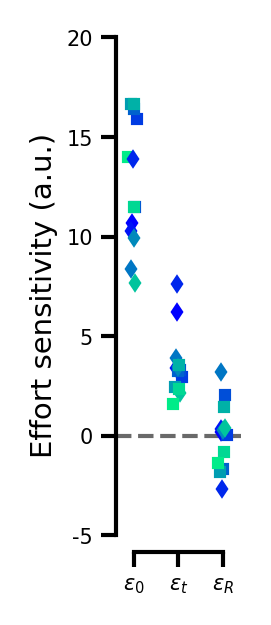

In [227]:
# epsilons distribution
# in fig 5

weights = {'RatF00': 212.02, 'RatF01': 205.85, 'RatF02': 193.75,
            'RatM00': 259.37, 'RatM01': 278.12, 'RatM02': 253.19,
            'RatF30': 217.32, 'RatF31': 228.95, 'RatF32': 216.80, 'RatF33': 222.77,
            'RatM30': 261.38, 'RatM31': 300.55, 'RatM32': 279.23, 
            'RatF40': 196.85, 'RatF41': 199.24, 'RatF42': 206.02,
            'RatM40': 238.70, 'RatM41': 238.19, 'RatM42': 242.87, 'RatM43': 262.23}



def Figure3X(ax=None):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    for animal in animalList:
        zorder=2
        if animal == 'RatF02':
            zorder = 10

        x = np.random.normal(0, 0.05)
        ax.plot(np.arange(3)+x,  [epsilon_0[animal], epsilon_t[animal], epsilon_R[animal]], 
                    color=rat_markers[animal][0], label=animal, 
                    marker=rat_markers[animal][1], markersize=2, lw=0, zorder=zorder)
    ax.set_xticks(np.arange(3))
    ax.set_xticklabels([r'$\epsilon_0$', r"$\epsilon_t$", r"$\epsilon_R$"])
    ax.set_xlim(0, 2)
    ax.set_ylim(-5, 20)
    ax.set_ylabel(f'Effort sensitivity (a.u.)')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, zorder=0)
    space_axes(ax, x_ratio_left=.2, x_ratio_right=.2)


fig, axs = plt.subplots(1, 1, figsize=(cm2inch(2), cm2inch(5)))
Figure3X(axs)

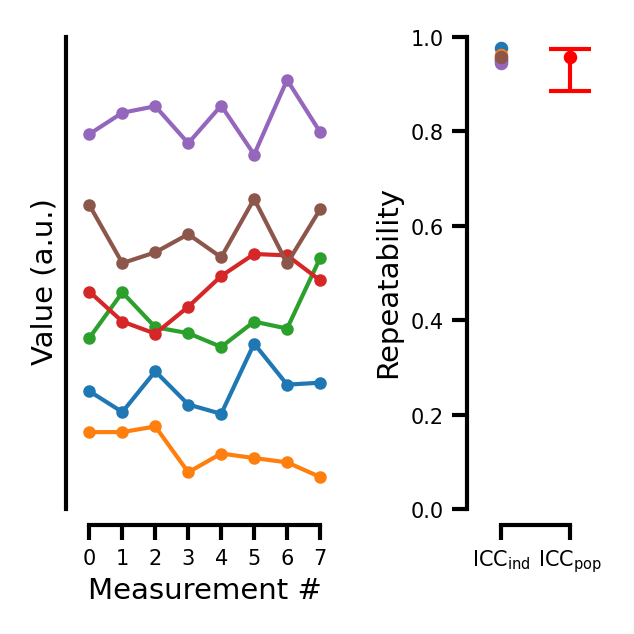

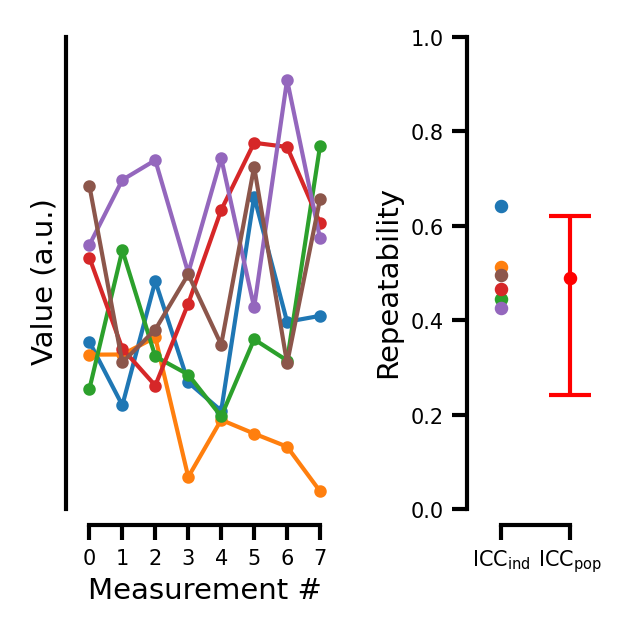

In [413]:
def do_stuff(var, name='', animalList=animalList):
    fig, axs = plt.subplots(1, 2, figsize=(2, 2), gridspec_kw={'width_ratios': [1, .5]})

    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]

    expected_60 = np.mean([var[animal]["60"] for animal in animalList])
    expected_90 = np.mean([var[animal]["90"] for animal in animalList])
    expected_120 = np.mean([var[animal]["120"] for animal in animalList])
    expected_20 = np.mean([var[animal]["20"] for animal in animalList])
    expected_10 = np.mean([var[animal]["10"] for animal in animalList])
    expected_2 = np.mean([var[animal]["2"] for animal in animalList])
    expected_rev10 = np.mean([var[animal]["rev10"] for animal in animalList])
    expected_rev20 = np.mean([var[animal]["rev20"] for animal in animalList])

    individual_intercepts = {}
    remaining_residuals = {}
    x = np.arange(len(conds))
    ymax = 0

    for animal in animalList:

        y = np.array([
            var[animal]["60"], 
                        var[animal]["90"], 
                        var[animal]["120"],
                        var[animal]["rev20"], 
                        var[animal]["rev10"], 
                        var[animal]["2"], 
                        var[animal]["10"], 
                        var[animal]["20"]])

        axs[0].plot(x, y, label=animal, marker='o', markersize=2)


        #############################""
        y_expected = np.array([
                                var[animal]["60"] - expected_60,
                                var[animal]["90"] - expected_90,
                                var[animal]["120"] - expected_120,
                                var[animal]["rev20"] - expected_rev20,
                                var[animal]["rev10"] - expected_rev10,
                                var[animal]["2"] - expected_2,
                                var[animal]["10"] - expected_10,
                                var[animal]["20"] - expected_20])




        #find intercept
        X = np.ones((len(x), 1))
        Y = y_expected.reshape(-1, 1)
        coefficients = np.linalg.lstsq(X, Y, rcond=None)[0]
        intercept = coefficients[0][0]
        individual_intercepts[animal] = intercept

        ######################################

        y_corrected = np.array([
                                var[animal]["60"] - expected_60 - individual_intercepts[animal],
                                var[animal]["90"] - expected_90 - individual_intercepts[animal],
                                var[animal]["120"] - expected_120 - individual_intercepts[animal],
                                var[animal]["rev20"] - expected_rev20 - individual_intercepts[animal],
                                var[animal]["rev10"] - expected_rev10 - individual_intercepts[animal],
                                var[animal]["2"] - expected_2 - individual_intercepts[animal],
                                var[animal]["10"] - expected_10 - individual_intercepts[animal],
                                var[animal]["20"] - expected_20 - individual_intercepts[animal]])
        
        remaining_residuals[animal] = np.var(y_corrected)

        temp_ymax = np.max(y)
        if temp_ymax > ymax:
            ymax = temp_ymax

    alp = np.var(list(individual_intercepts.values()))
    eps = np.mean(list(remaining_residuals.values()))
    ICC_pop = alp / (alp + eps)

    axs[0].set_ylabel("Value (a.u.)")
    axs[0].set_xticks(x)
    axs[0].set_xlabel("Measurement #")
    axs[0].set_xlim(0, 7)
    axs[0].set_ylim(0, 1.1*ymax)
    space_axes(axs[0], x_ratio_left=.1, x_ratio_right=.1)
    axs[0].set_yticks([])
    axs[0].set_yticklabels([])



    # individual ICC
    ICC_indiv = {}
    for animal in animalList:
        ICC_indiv[animal] = alp / (alp + remaining_residuals[animal])
        axs[1].scatter(0,  ICC_indiv[animal], s=5)
    


    # compute_ICC(var)
    conf_bottom, conf_top = bootstrap_ICC(var, animalList, num_bootstrap=1000 )
    axs[1].scatter(0.1, ICC_pop, color='r', s=5)
    axs[1].errorbar(0.1, ICC_pop, yerr=[[ICC_pop - conf_bottom], [conf_top - ICC_pop]], color='r', capsize=5, capthick=1)
    axs[1].set_ylim(0, 1)
    axs[1].set_xlim(0, 0.1)
    axs[1].set_xticks([0, 0.1])
    axs[1].set_xticklabels([r"$\mathrm{ICC_{ind}}$", r"$\mathrm{ICC_{pop}}$"])
    axs[1].set_ylabel("Repeatability")
    space_axes(axs[1], x_ratio_left=.5, x_ratio_right=.5)
    
    
    plt.show()




def mock_dataset(n_subjects=animalList, n_measurements=["60", "90", "120", "rev20", "rev10", "2", "10", "20"], noise=0):
    np.random.seed(2007)
    data = {}
    expected_value = np.arange(len(n_measurements))/10+ np.random.rand(len(n_measurements))/5
    expected_value *= 0
    individual_intercept = np.random.rand(len(n_subjects))

    for i, animal in enumerate(n_subjects):
        data[animal] = {}
        # for j in range(len(n_measurements)):
        for j, cond in enumerate(n_measurements):
            data[animal][cond] = expected_value[j] + individual_intercept[i] + np.random.rand() * noise
    return data
N = 6
do_stuff(mock_dataset(noise=0.25), '', animalList=animalList[:N])
do_stuff(mock_dataset(noise=1.5), '', animalList=animalList[:N])

In [249]:
import numpy as np
from scipy import stats

# Generate example data
np.random.seed(42)
n_subjects = 10
n_measurements = 8
NOISE=.1

subject_ids = np.repeat(range(n_subjects), n_measurements)
expected_value = np.random.randn(n_subjects)
individual_intercepts = np.random.randn(n_subjects)
measurements = expected_value[subject_ids] + individual_intercepts[subject_ids] + np.random.randn(n_subjects * n_measurements) * NOISE

# Create a DataFrame with correct lengths
data = {'subject_id': subject_ids, 'measurement': measurements, 
        'expected_value': np.repeat(expected_value, n_measurements), 
        'individual_intercept': np.repeat(individual_intercepts, n_measurements)}

# Calculate total mean and within-subject mean
total_mean = np.mean(measurements)
within_subject_means = np.array([np.mean(measurements[subject_ids == subject_id]) for subject_id in range(n_subjects)])
print(within_subject_means)
# Calculate variance components
between_subjects_variance = np.var(within_subject_means)
within_subjects_variance = np.mean(np.square(measurements - within_subject_means[subject_ids]), axis=0)

print(measurements, within_subject_means[subject_ids])

# Calculate ICC
ICC = between_subjects_variance / (between_subjects_variance + within_subjects_variance)
print("Intraclass Correlation Coefficient (ICC):", ICC)

# Intra-individual variance
intra_individual_variance = np.array([np.var(measurements[subject_ids == subject_id]) for subject_id in range(n_subjects)])
indiv_ICC = between_subjects_variance / (between_subjects_variance + intra_individual_variance)
print("Individual ICC:", indiv_ICC)

[ 0.01672017 -0.6178849   0.8597877  -0.42877917 -1.93337855 -0.79476306
  0.58321824  1.06904826 -1.36520931 -0.90171411]
[ 0.17986134  0.01071883  0.04004928 -0.10917836 -0.02114181  0.04438872
 -0.0818029   0.07086626 -0.66405792 -0.63316343 -0.66416472 -0.41876624
 -0.60534378 -0.70976515 -0.52173956 -0.72607842  0.91053717  0.6936838
  0.7568322   0.90933693  0.96349747  0.90678764  0.87808598  0.85954044
 -0.53810259 -0.46223481 -0.43631427 -0.28453817 -0.35588856 -0.5665544
 -0.35784199 -0.42875862 -2.02676341 -1.89790358 -1.85597125 -1.8659432
 -2.04299296 -1.98999244 -1.92594486 -1.86151669 -0.84434191 -0.81499038
 -0.90705798 -0.91604515 -0.7151719  -0.66080048 -0.8036255  -0.6960712
  0.6025453   0.50186972  0.60252126  0.72018535  0.56279909  0.72284606
  0.30440718  0.64857195  1.09038677  1.05178133  1.09085814  0.88292517
  1.05971487  1.11739332  1.22947147  1.02985504 -1.45834782 -1.42767417
 -1.28595825 -1.34462335 -1.43047448 -1.32617172 -1.36779071 -1.28063396
 -0.9

(-0.1, 0.2)

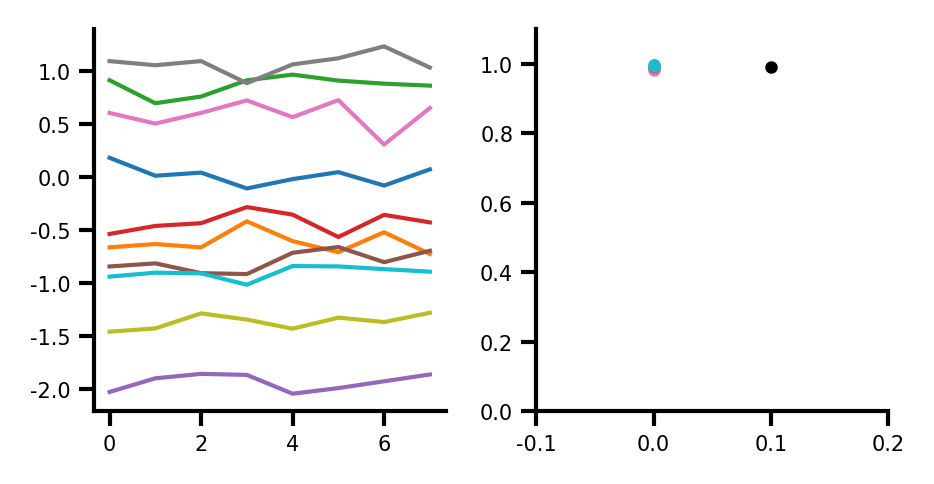

In [250]:
fig, axs = plt.subplots(1, 2, figsize=(3, 1.5))
for subj in np.arange(n_subjects):
    axs[0].plot(np.arange(n_measurements), [data['measurement'][data['subject_id'] == subj][meas] for meas in np.arange(n_measurements)])
        # print(subj, meas, data['measurement'][data['subject_id'] == subj][meas])
    axs[1].plot(0, indiv_ICC[subj], 'o', ms=2)

axs[1].plot(0.1, ICC, 'o', color='black', ms=2)
axs[1].set_ylim(0, 1.1)
axs[1].set_xlim(-0.1, 0.2)